# Herramientas

### Sumario
1. Clase `Tool`
2. Clase `StructuredTool`
3. Subclase de `BaseTool`
    1. Único parámetro
    2. Múltiples parámetros
    3. Ej.: Agente con reconocimiento de imágenes

In [1]:

from os import getenv
from dotenv import load_dotenv
from langchain_openai import OpenAI


load_dotenv()
#client = OpenAI(api_key=getenv('API_KEY_DALLE'))

#Nombre del despliegue en OpenAI Studio, el modelo es 'text-davinci-003'
#engine = 'Davinci003'
model = 'gpt-3.5-turbo-instruct'
#openai_api_version = '2023-12-01'

#Nombre del despliegue para el modelo de embeddings es 'TextEmbeddingAda002'
embeddings_engine = 'TextEmbeddingAda002'

max_tokens = 1000

llm = OpenAI(openai_api_key=getenv('OPEN_API_KEY', ''),
                 model= model,
                 #engine=engine,
                 #openai_api_version=openai_api_version,
                 temperature=0.2)

llm.max_tokens = max_tokens


In [2]:
from langchain.callbacks import get_openai_callback
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

def call_agent_with_translate(agent, es_eng_chain, eng_es_chain, query):
    print(f'Input: {query}')

    with get_openai_callback() as cb:
        query_translated = es_eng_chain(query)['text']
        query_translated = query_translated.replace('\n', '')
        es_eng_token_count = cb.total_tokens
    print(f'Input (traducido al inglés): {query_translated}')

    with get_openai_callback() as cb:
        result = agent(query_translated)
        agent_token_count = cb.total_tokens
    print(f"Output: {result['output']}")

    with get_openai_callback() as cb:
        output_translated = eng_es_chain(result['output'])['text']
        output_translated = output_translated.replace('\n', '')
        eng_es_token_count = cb.total_tokens
    print(f'Output (traducido al español): {output_translated}')

    total_tokens = es_eng_token_count + agent_token_count + eng_es_token_count

    print(f'He usado un total de {total_tokens} tokens')

    return result

#Chain para traducir el texto de entrada de español a inglés
translate_eng_es_prompt = ChatPromptTemplate.from_template(
        "Translate the following spanish text to english (write only the translated text): {input}"
    )

translate_eng_es_chain = LLMChain(llm=llm, prompt=translate_eng_es_prompt)

#Chain para traducir el texto de salida del modelo de inglés a español
translate_es_eng_prompt = ChatPromptTemplate.from_template(
        "Si el siguiente texto está en inglés, tradúcelo al español, en caso contrario, simplemente devuelve el mismo texto: {input}"
    )

translate_es_eng_chain = LLMChain(llm=llm, prompt=translate_es_eng_prompt)

## 1 - Clase `Tool`

El enfoque más simple para definir una herramienta en LangChain. La dataclass Tool encapsula funciones que aceptan un único string de entrada y devuelven un string de salida

In [3]:
from langchain.tools import Tool

def return_hash(input: str):
    return str(hash(input))

hash_tool = Tool.from_function(
    func=return_hash,
    name="Hash",
    description="Useful for when you need to estimate the hash of an input"
)

In [4]:
from langchain.utilities import WikipediaAPIWrapper

wiki = WikipediaAPIWrapper(
    doc_content_chars_max = 2000
)

wiki_tool = Tool.from_function(
    func=wiki.run,
    name = 'Wikipedia',
    description='Wikipedia, useful for when you need to answer question about history, science, biology, sport, etc.'

)

In [5]:
from pydantic import BaseModel, Field
from langchain import LLMMathChain

llm_math_chain = LLMMathChain.from_llm(llm=llm, verbose=True)
calculator_tool = Tool.from_function(
    func=llm_math_chain.run,
    name="Calculator",
    description="Useful for when you need to answer questions about math"
)

In [6]:
from langchain.agents import AgentType, initialize_agent

tools = [hash_tool, wiki_tool, calculator_tool]

zero_shot_agent_executor = initialize_agent(
    tools,
    llm,
    ag=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

result = call_agent_with_translate(
    zero_shot_agent_executor,
    translate_eng_es_chain,
    translate_es_eng_chain,
    '¿Cuánta gente vive en Tokio?'
)

c:\Users\rafacampa9\.virtualenvs\Langchain-NIv1GH6l\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(
c:\Users\rafacampa9\.virtualenvs\Langchain-NIv1GH6l\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Input: ¿Cuánta gente vive en Tokio?
Input (traducido al inglés): How many people live in Tokyo?


> Entering new AgentExecutor chain...
 I should use Wikipedia to find the population of Tokyo
Action: Wikipedia
Action Input: Tokyo
Observation: Page: Tokyo
Summary: Tokyo (; Japanese: 東京, Tōkyō, [toːkʲoː] ), officially the Tokyo Metropolis (東京都, Tōkyō-to), is the capital of Japan and one of the most populous cities in the world with a population of over 14 million residents as of 2023. The Tokyo metropolitan area, which includes Tokyo and nearby prefectures, is the world's most-populous metropolitan area, with 40.8 million residents as of 2023, and is the second-largest metropolitan economy in the world after New York, with a 2022 gross metropolitan product estimated at US$2.08 trillion (US$51,124 per capita).Located at the head of Tokyo Bay, Tokyo is part of the Kantō region on the central coast of Honshu, Japan's largest island. Tokyo serves as Japan's economic center and the seat of bo

In [7]:
result = call_agent_with_translate(
    zero_shot_agent_executor,
    translate_eng_es_chain,
    translate_es_eng_chain,
    '¿Cuál es el resultado de multiplicar el hash de la palabra Everest por 0.005?'
)

Input: ¿Cuál es el resultado de multiplicar el hash de la palabra Everest por 0.005?
Input (traducido al inglés): What is the result of multiplying the hash of the word Everest by 0.005?


> Entering new AgentExecutor chain...
 I need to find the hash of the word Everest and then multiply it by 0.005
Action: [Hash, Calculator]
Action Input: [Everest, 0.005]
Observation: [Hash, Calculator] is not a valid tool, try one of [Hash, Wikipedia, Calculator].
Thought: I can use the calculator to multiply the hash of Everest by 0.005
Action: Calculator
Action Input: (hash of Everest) * 0.005

> Entering new LLMMathChain chain...
(hash of Everest) * 0.005```text
hash(Everest) * 0.005
```
...numexpr.evaluate("hash(Everest) * 0.005")...


ValueError: LLMMathChain._evaluate("
hash(Everest) * 0.005
") raised error: 'VariableNode' object is not callable. Please try again with a valid numerical expression

In [ ]:
everest_hash = return_hash('Everest')
print(f'Hash: {everest_hash}\nResult: {float(everest_hash)*0.005}')

Hash: -3788660673711316827
Result: -1.8943303368556584e+16


# 2 - Clase `StructuredTool`

Con la clase `Tool` podemos usar nuestras propias funciones, pero estamos limitados a `str -> str`. Si queremos utilizar funciones con argumentos más estructurados podemos usar la clase `StructuredTool`

In [ ]:
from langchain.tools import StructuredTool

# Es importante que indiquemos el tipo de los parámetros que dan
# información al agente
def avg_2_nums(num1: float, num2: float) -> float:
    return (num1 + num2)/2

avg_2_nums_tool = StructuredTool.from_function(
    func=avg_2_nums,
    name='Average_two_numbers',
    description='Useful for when you need to estimate the average of two numbers'
)

structured_agent_executor = initialize_agent(
    [avg_2_nums_tool],
    llm,
    agent = AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)


In [ ]:
print(structured_agent_executor.agent.llm_chain.prompt.messages[0].prompt.template)

Respond to the human as helpfully and accurately as possible. You have access to the following tools:

Average_two_numbers: Average_two_numbers(num1: float, num2: float) -> float - Useful for when you need to estimate the average of two numbers, args: {{'num1': {{'title': 'Num1', 'type': 'number'}}, 'num2': {{'title': 'Num2', 'type': 'number'}}}}

Use a json blob to specify a tool by providing an action key (tool name) and an action_input key (tool input).

Valid "action" values: "Final Answer" or Average_two_numbers

Provide only ONE action per $JSON_BLOB, as shown:

```
{{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}}
```

Follow this format:

Question: input question to answer
Thought: consider previous and subsequent steps
Action:
```
$JSON_BLOB
```
Observation: action result
... (repeat Thought/Action/Observation N times)
Thought: I know what to respond
Action:
```
{{
  "action": "Final Answer",
  "action_input": "Final response to human"
}}
```

Begin! Reminder to ALWAYS re

In [17]:
result = call_agent_with_translate(
    structured_agent_executor,
    translate_eng_es_chain,
    translate_es_eng_chain,
    "Cuál es la media de 3.7 y 7.75?"
)

Input: Cuál es la media de 3.7 y 7.75?
Input (traducido al inglés): What is the average of 3.7 and 7.75?


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Average_two_numbers",
  "action_input": {
    "num1": 3.7,
    "num2": 7.75
  }
}
```


Observation: 5.725
Thought: I know what to respond
Action:
```
{
  "action": "Final Answer",
  "action_input": "The average of 3.7 and 7.75 is 5.725."
}
```

> Finished chain.
Output: The average of 3.7 and 7.75 is 5.725.
Output (traducido al español): El promedio de 3.7 y 7.75 es 5.725.
He usado un total de 908 tokens


Vamos a hacer un ej un poco más complejo donde simulamos que enviamos un correo a una dirección y le vamos a pedir al agente que por favor lo envíe.

In [27]:
from time import sleep
from random import random

# Función donde simulamos el envío de un correo electrónico cuyo éxito es del 50%
# (para mostrar cómo se comporta el agente en cada caso)
def send_email(address: str, header: str, message: str) -> str:
    print(f'Enviado email a la dirección: {address}')

    if random() < 0.5:  
        for i in range (3, 0, -1):
            print(f'Enviando, por favor espere... {i}')
            sleep(1)

        print('Enviado correctamente')
        print(f'Cabecero: {header}')
        print(f'Mensaje: {message}')

        return 'Success'
    else:
        return "Error"
    
send_email("test@gmail.com", "Prueba", "Hola Mundo")

Enviado email a la dirección: test@gmail.com
Enviando, por favor espere... 3
Enviando, por favor espere... 2
Enviando, por favor espere... 1
Enviado correctamente
Cabecero: Prueba
Mensaje: Hola Mundo


'Success'

In [28]:
send_email_tool = StructuredTool.from_function(
    func=send_email,
    name='send_email',
    description='Useful when you need to send an email to a specific address'
)

structured_agent_executor = initialize_agent(
    [send_email_tool],
    llm,
    agent = AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

In [30]:
result = call_agent_with_translate(
    structured_agent_executor,
    translate_eng_es_chain,
    translate_es_eng_chain,
    "Envía un correo a test@gmail.com con el mensaje 'Hola Zaraki, qué tal ser un Kenpachi?' y un cabecero del mail que consideres apropiado. Debes escribirlo en ESPAÑOL"
)

Input: Envía un correo a test@gmail.com con el mensaje 'Hola Zaraki, qué tal ser un Kenpachi?' y un cabecero del mail que consideres apropiado. Debes escribirlo en ESPAÑOL
Input (traducido al inglés): Send an email to test@gmail.com with the message 'Hello Zaraki, how about being a Kenpachi?' and a header for the email that you consider appropriate. You must write it in ENGLISH


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "send_email",
  "action_input": {
    "address": "test@gmail.com",
    "header": "Kenpachi Invitation",
    "message": "Hello Zaraki, how about being a Kenpachi?"
  }
}
```

Enviado email a la dirección: test@gmail.com
Enviando, por favor espere... 3
Enviando, por favor espere... 2
Enviando, por favor espere... 1
Enviado correctamente
Cabecero: Kenpachi Invitation
Mensaje: Hello Zaraki, how about being a Kenpachi?

Observation: Success
Thought: I know what to respond
Action:
```
{
  "action": "Final Answer",
  "action_input": "Email sent successfu

# 3 - Subclase de `BaseTool`

Otra opción es subclasificar directamente `BaseTool`. Esto es útil si queremos tener más control sobre las variables o si queremos propagar callbacks de llamada a cadenas anidadas u otras herramientas.

Este enfoque se puede utilizar para definir herramientas que requieren uno o más parámetros.

## 3.1 - Único parámetro

Vamos a empezar con una herramienta simple donde estimamos la circunferencia de un círculo a partir de su radio.

La idea sería utilizar esta herramienta para responder preguntas como la siguiente:
`Puedes decirme cuál es la circunferencia de un círculo con radio 7.81mm?`

In [31]:
from langchain.tools import BaseTool
from math import pi
from typing import Callable, Optional, Union

class CircumferenceTool(BaseTool):
    name = "Circumference calculator"
    description = 'Use this tool when you need to calculate a circumference using the radius of a circle'

    def _run(self, radius: Union[int, float]):
        return float(radius)*2.0*pi
    
    def _arun(self, radius: int):
        raise NotImplementedError('This tool does not support async')

Al igual que vimos más arriba, LangChain requiere dos atributos para reconocer un obj como una herramienta válida. Estos son los parámetros `name` y `description`.

A continuación, tenemos dos métodos: `_run()` y `_arun()`. Cuando se usa una herramienta, se llama al método `_run()` de forma predeterminada. Se llama al método `_arun()` cuando se debe usar una herramienta de forma asíncrona.

A partir de aquí, creamos un agente conversacional simple

In [32]:
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.agents import initialize_agent

circumference_conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5, 
    return_messages=True
)

#initialize agent with tools
circumference_agent_executor = initialize_agent(
    agent = AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    tools=[CircumferenceTool()],
    llm=llm,
    verbose=True,
    max_iterations=10,
    #early_stopping_method: Si se para el modelo antes de tiempo (p. ej., si se ha metido en un bucle)
    # el output resultante considera todo lo que ha hecho hasta el momento para dar una mejor respuesta
    early_stopping_method='generate',
    memory=circumference_conversational_memory
)

In [33]:
result = call_agent_with_translate(
    circumference_agent_executor,
    translate_eng_es_chain,
    translate_es_eng_chain,
    'Puedes decirme cuál es la circunferencia de un círculo con radio 7.81mm?'
)

Input: Puedes decirme cuál es la circunferencia de un círculo con radio 7.81mm?
Input (traducido al inglés): Can you tell me what is the circumference of a circle with a radius of 7.81mm?


> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Circumference calculator
Action Input: 7.81
Observation: 49.071677249072565
Thought: Do I need to use a tool? No
AI: The circumference of a circle with a radius of 7.81mm is approximately 49.07mm. Is there anything else you would like to know?

> Finished chain.
Output: The circumference of a circle with a radius of 7.81mm is approximately 49.07mm. Is there anything else you would like to know?
Output (traducido al español): La circunferencia de un círculo con un radio de 7.81 mm es aproximadamente 49.07 mm. ¿Hay algo más que te gustaría saber?
He usado un total de 1080 tokens


`Nota`:

Si nos encontramos con un `ValueError` porque el LLM decide pasar directamente "7.81mm" a la calculadora en lugar de "7.81".

Cuando una herramienta encuentra un error y la excepción no se captura, el agente dejará de ejecutarse. Si desea que el agente continúe su ejecución, puede lanzar un `ToolException` y configurar `handle_tool_error` en consecuencia.

Cuando se lanza un `ToolException`, el agente no deja de funcionar. En cambio, manejará la excepción de acuerdo con la variable `handle_tool_error` de la herramienta, y el resultado del procesamiento se devolverá al agente como observación y se imprimirá en rojo

In [34]:
from langchain.tools.base import ToolException

def handle_error(error: ToolException) -> str:
    return f"The following errors occurred during tool execution: {error.args[0]}"

class SafeCircumferenceTool(BaseTool):
    name: str = "Circumference calculator with exception handling"
    description: str = "use this tool when you need to calculate a circumference using the radius of a circle."
    handle_tool_error: Optional [
        Union[bool, str, Callable[[ToolException], str]]
    ] = handle_error

    def _run(self, radius: Union[int, float]):
        try:
            return float(radius)*2.0*pi
        except ValueError as e:
            raise ToolException(e.args[0])
        
    def _arun(self, radius: int):
        raise NotImplementedError("This tool does not support async")

In [35]:
safe_circumference_conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

#initialize agent with tools
safe_circumference_agent_executor = initialize_agent(
    agent = AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    tools=[SafeCircumferenceTool()],
    llm=llm,
    verbose=True,
    max_iterations=10,
    early_stopping_method='generate',
    memory=safe_circumference_conversational_memory
)

In [36]:
result = call_agent_with_translate(
    safe_circumference_agent_executor,
    translate_eng_es_chain,
    translate_es_eng_chain,
    'Puedes decirme cuál es la circunferencia de un círculo con radio 9.82mm?'
)

Input: Puedes decirme cuál es la circunferencia de un círculo con radio 9.82mm?
Input (traducido al inglés): Can you tell me what is the circumference of a circle with a radius of 9.82mm?


> Entering new AgentExecutor chain...

Thought: Do I need to use a tool? Yes
Action: Circumference calculator with exception handling
Action Input: 9.82
Observation: 61.700879716503536
Thought: Do I need to use a tool? No
AI: The circumference of a circle with a radius of 9.82mm is approximately 61.7mm. Is there anything else you would like to know?

> Finished chain.
Output: The circumference of a circle with a radius of 9.82mm is approximately 61.7mm. Is there anything else you would like to know?
Output (traducido al español): La circunferencia de un círculo con un radio de 9.82 mm es aproximadamente 61.7 mm. ¿Hay algo más que te gustaría saber?
He usado un total de 1099 tokens


Podemos ver que el agente no se bloquea en este ejemplo, pero tampoco puede comprender correctamente qué debe hacer con el error. Podríamos abordar este problema desde varias perspectivas diferentes:

* Reformular nuestra pregunta para que el agente pueda entenderla.
* Mejorar la herramienta para que preprocese auto la entrada para evitar un `ValueError`. P. ej., podemos poner un paso intermedio que traduzca el input que recibe el método en un valor numérico. Esto podría hacerse con un LLM.
* Generar prompts para el modelo para que pueda comprender cómo debe comportarse con un error de formato de este tipo. P. ej., reintentándolo mediante una modificación del input.


## 3.2 - Múltiples parámetros

En la calculadora de circunferencias solo podíamos ingresar un único valor (es decir, el radio). Sin embargo, a menudo necesitaremos múltiples parámetros.

Para demostrar cómo hacerlo, construiremos una calculadora de hipotenusas. La herramienta nos ayudará a calcular la hipotenusa de un triángulo dada una combinación de longitudes de lados y/o ángulos del triángulo.

Queremos múltiples entradas aquí porque calculamos la hipotenusa del triángulo con diferentes valores (los lados y el ángulo).

In [37]:
from math import degrees, sqrt, atan2

def angulos_triangulo_dos_lados(a, b):
    c = sqrt(a**2 + b**2)

    angulo_alpha = degrees(atan2(b, a))
    angulo_rect = 90.0
    angulo_theta = 180.0 - angulo_alpha - angulo_rect

    angulo_adyacente = angulo_theta
    angulo_opuesto = angulo_alpha

    return angulo_adyacente, angulo_opuesto


a = 10
b = 6

angulos = angulos_triangulo_dos_lados(a, b)
print(f'Ángulo adyacente (theta en nuestro diagrama): {angulos[0]:.2f} grados')


Ángulo adyacente (theta en nuestro diagrama): 59.04 grados


In [38]:
from typing import Optional
from math import sqrt, cos, sin, radians

desc = (
    "use this tool when you need to calculate the length of a hypotenuse "
    "given one or two sides of a triangle and/or an angle (in degrees). "
    "To use the tool, you must provide at least two of the following parameters "
    "['adjacent_side', 'opposite_side', 'angle']. Parameters are float numbers."
)

class HypotenuseTool(BaseTool):
    name = 'hypotenuse_calculator'
    description = desc

    def _run(
            self,
            adjacent_side: Optional[Union[int, float]] = None,
            opposite_side: Optional[Union[int, float]] = None,
            angle: Optional[Union[int, float]] =None
    ):
        #Check for the values we have been given
        if adjacent_side and opposite_side:
            return sqrt(float(adjacent_side)**2 + float(opposite_side)**2)
        elif adjacent_side and angle:
            return adjacent_side / cos(radians(float(angle)))
        elif opposite_side and angle:
            return opposite_side / sin(radians(float(angle)))
        else:
            return "Could not calculate the hypotenuse of the triangle. Need two or more of `adjacent_side`, `opposite_side`, `angle`"

`Nota`: Al igual que con `StructuredTool.from_function()`, las herramientas con múltiples inputs sona día de hoy solo compatible con el agente `STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION`

In [39]:
hypotenuse_conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

hypotenuse_agent_executor = initialize_agent(
    agent = AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    llm=llm,
    tools=[HypotenuseTool()],
    verbose=True,
    max_iterations=3,
    early_stopping_method='generate',
    memory=hypotenuse_conversational_memory
)

In [40]:
result = call_agent_with_translate(
    hypotenuse_agent_executor,
    translate_eng_es_chain,
    translate_es_eng_chain,
    'Si tengo un triángulo rectángulo con dos lados de 10 cm y 6 cm de longitud, ¿qué longitud tiene la hipotenusa?'
)

Input: Si tengo un triángulo rectángulo con dos lados de 10 cm y 6 cm de longitud, ¿qué longitud tiene la hipotenusa?
Input (traducido al inglés): If I have a right triangle with two sides of 10 cm and 6 cm in length, what is the length of the hypotenuse?


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "hypotenuse_calculator",
  "action_input": {
    "adjacent_side": 10,
    "opposite_side": 6
  }
}
```


Observation: 11.661903789690601
Thought: I think I got the right answer, but I should double check.
Action:
```
{
  "action": "Final Answer",
  "action_input": "The length of the hypotenuse is 11.661903789690601 cm."
}
```


> Finished chain.
Output: The length of the hypotenuse is 11.661903789690601 cm.
Output (traducido al español): La longitud de la hipotenusa es 11.661903789690601 cm.
He usado un total de 1164 tokens


In [41]:
result = call_agent_with_translate(
    hypotenuse_agent_executor,
    translate_eng_es_chain,
    translate_es_eng_chain,
    'Si tengo un triángulo rectángulo con un lado que mide 10 cm de longitud y su ángulo es de 30.96 grados, ¿qué longitud tiene la hipotenusa?'
)

Input: Si tengo un triángulo rectángulo con un lado que mide 10 cm de longitud y su ángulo es de 30.96 grados, ¿qué longitud tiene la hipotenusa?
Input (traducido al inglés): If I have a right triangle with one side measuring 10 cm in length and its angle is 30.96 degrees, what is the length of the hypotenuse?


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "hypotenuse_calculator",
  "action_input": {
    "adjacent_side": 10,
    "angle": 30.96
  }
}
```


Observation: 11.661445073191679
Thought: This is the correct answer.
Action:
```
{
  "action": "Final Answer",
  "action_input": "The length of the hypotenuse is 11.661445073191679 cm."
}
```


> Finished chain.
Output: The length of the hypotenuse is 11.661445073191679 cm.
Output (traducido al español): La longitud de la hipotenusa es 11.661445073191679 cm.
He usado un total de 1181 tokens


In [42]:
result = call_agent_with_translate(
    hypotenuse_agent_executor,
    translate_eng_es_chain,
    translate_es_eng_chain,
    'Si tengo un triángulo rectángulo con un lado que mide 6 cm de longitud y su `ángulo opuesto` es de 30.96 grados, ¿qué longitud tiene la hipotenusa?'
)

Input: Si tengo un triángulo rectángulo con un lado que mide 6 cm de longitud y su `ángulo opuesto` es de 30.96 grados, ¿qué longitud tiene la hipotenusa?
Input (traducido al inglés): If I have a right triangle with one side measuring 6 cm in length and its opposite angle is 30.96 degrees, what is the length of the hypotenuse?


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "hypotenuse_calculator",
  "action_input": {
    "adjacent_side": 6,
    "angle": 30.96
  }
}
```


Observation: 6.996867043915008
Thought: The hypotenuse calculator tool returned the correct length of the hypotenuse.
Action:
```
{
  "action": "Final Answer",
  "action_input": "The length of the hypotenuse is 6.996867043915008 cm."
}
```


> Finished chain.
Output: The length of the hypotenuse is 6.996867043915008 cm.
Output (traducido al español): La longitud de la hipotenusa es de 6.996867043915008 cm.
He usado un total de 1199 tokens


# 3.3 - Ejemplo: Agente de reconocimiento de imágenes

Si bien ya hemos visto dos ejs de cómo crear herramientas personalizadas con `BaseTool`, lo cierto es que su utilidad era algo limitada. Por ello, vamos a mostrar un caso de uso "más potente".

Tomaremos un modelo "experto" que ha sido entrenado en una tarea específica que nuestro LLM no puede realizar. En este caso vamos a utilizar `BLIP`, un modelo desarrollado por Salesforce, el cual toma una imagen y la describe.

pip install transformers

In [1]:
from torch.cuda import is_available as cuda_available
from transformers import BlipProcessor, BlipForConditionalGeneration

hf_model = "Salesforce/blip-image-captioning-base"
device = 'cuda' if cuda_available() else 'cpu'

#preprocessor will prepare images for the model
processor = BlipProcessor.from_pretrained(hf_model)
#then we initialze the model itself
model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)

c:\Users\rafacampa9\.virtualenvs\Langchain-NIv1GH6l\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rafacampa9\.virtualenvs\Langchain-NIv1GH6l\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rafacampa9\.cache\huggingface\hub\models--Salesforce--blip-image-captioning-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run 

El proceso que seguiremos aquí es el siguiente:

* Descargamos una imagen
* La abrimos como un obj PIL en Python
* Cambia el tamaño y normaliza la imagen utilizando el "procesador" asociado a BLIP
* Pasamos la imagen procesada por el modelo BLIP

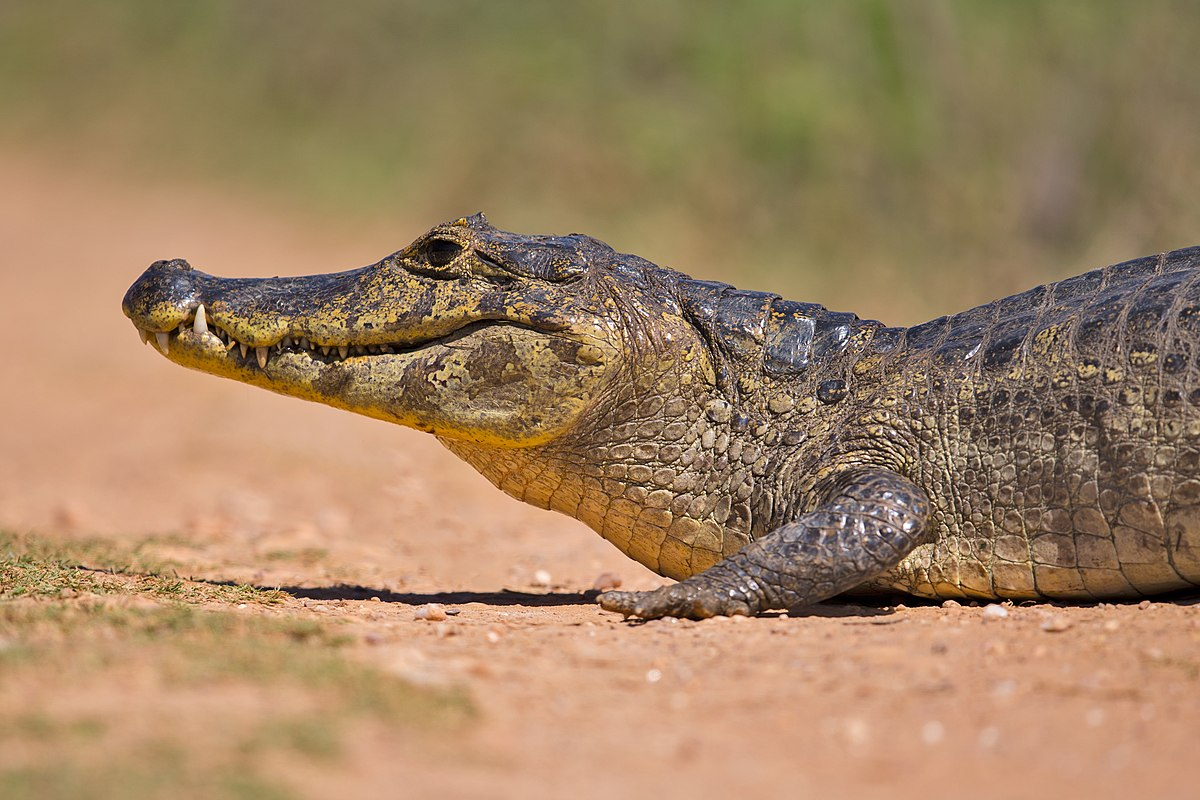

In [3]:
from requests import get as reqGet
from urllib.request import urlretrieve
from PIL import Image as pilImage

#Descargamos la imagen
img_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Brillenkaiman_Caiman_yacare.jpg/1200px-Brillenkaiman_Caiman_yacare.jpg'
urlretrieve(img_url, 'img.jpg')

#Cargamos la imagen
image = pilImage.open(reqGet(img_url, stream=True).raw).convert("RGB")
image

Veamos que es lo que dice nuestro modelo al ver la imagen

In [4]:
#Procesamos la imagen
inputs = processor(image, return_tensors='pt').to(device)

# La pasamos por el modelo BLIP
out = model.generate(**inputs, max_new_tokens=20)
print(processor.decode(out[0], skip_special_tokens=True))

a crocodile in the wild


Con esto, confirmamos que el proceso funciona correctamente. El siguiente paso es destilar los pasos que hemos seguido en una herramienta que el agente pueda utilizar:

In [26]:
from langchain.tools import BaseTool
class ImageCaptionTool(BaseTool):
    name = 'image_captioner'
    description = (
            "use this tool when given the URL of an image that you'd like to be "
            "described. It will return a simple caption describing the image"
        )
    


    def _run(self, url: str):
        #Descarga la imagen y la convierte en un objeto PIL
        urlretrieve(url, "img.jpg")
        image = pilImage.open(reqGet(img_url, stream=True).raw).convert("RGB")
        #Preprocesa la imagen
        inputs = processor(image, return_tensors='pt').to(device)
        #Pasa el input por el modelo y genera el caption
        out = model.generate(**inputs, max_new_tokens=20)
        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption
    
    def _arun(self, query: str):
        raise NotImplementedError('this tool does not support async')


In [27]:
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.agents import initialize_agent

blip_conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

blip_agent_executor = initialize_agent(
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    tools=[ImageCaptionTool()],
    llm=llm,
    verbose=True,
    max_iterations=10,
    early_stopping_method='generate',
    memory=blip_conversational_memory
)

In [28]:
blip_agent_executor(f"What does this image show?\n{img_url}")



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "image_captioner",
  "action_input": {
    "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Brillenkaiman_Caiman_yacare.jpg/1200px-Brillenkaiman_Caiman_yacare.jpg"
  }
}
```



AttributeError: 'str' object has no attribute 'generate'